# Copyright Netherlands eScience Center <br>
** Function     : Compare OMET from highResMIP and observation** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.08.19 ** <br>
** Last Update  : 2019.08.19 ** <br>
Description     : This notebook aims to compare OMET from fully coupled high resolution historical and control runs (HadGEM + NEMO) and observations from RAPID ARRAY and OSNAP. It contributes to the Deliverable 2.4. <br>
Return Values   : netCDF4 <br>
Caveat          : The time coverage of the simulations are:
* control run is from 1950 to 2050 (101 years)
* historical run is from 1950 to 2014 (65 years)
* RAPID ARRAY is from Apr, 2004 to Oct, 2015
* OSNAP is from Aug, 2014 to Apr, 2016

In [1]:
%matplotlib inline
import numpy as np
import sys
sys.path.append("../Analysis")
import analyzer
import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
################################   Input zone  ######################################
# specify starting and ending time
# specify data path
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
datapath_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/postprocessing'
datapath_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/postprocessing'
datapath_hindcast = '/home/ESLT0068/NLeSC/Computation_Modeling/BlueAction/WP2/Oceanography/ORCA083hindcast_BenMoat'

datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/hiresMIP_BenMoat/D2.4'
datapath_RAPID = '/home/ESLT0068/NLeSC/Computation_Modeling/BlueAction/WP2/Oceanography/RAPID_ARRAY'
datapath_OSNAP = '/home/ESLT0068/NLeSC/Computation_Modeling/BlueAction/WP2/Oceanography/OSNAP'

# mask
datapath_mask_ORAS4 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_mask_GLORYS2V3 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3'
datapath_mask_SODA3 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3'
# specify output path for figures
output_path = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/hiresMIP_BenMoat/D2.4'
####################################################################################

In [4]:
################################   Extract variables  ######################################
dataset_ORAS4_point = Dataset(os.path.join(datapath_ORAS4,
                              'oras_model_monthly_1958_2017_omet.nc'))
dataset_GLORYS2V3_point = Dataset(datapath_GLORYS2V3 + os.sep + 'GLORYS2V3_model_monthly_orca025_E_point.nc')
dataset_SODA3_point = Dataset(os.path.join(datapath_SODA3,
                              'OMET_SODA3_model_5daily_1980_2015_E_point.nc'))
dataset_mask_ORAS4 = Dataset(datapath_mask_ORAS4 + os.sep + 'mesh_mask.nc')
dataset_mask_GLORYS2V3 = Dataset(datapath_mask_GLORYS2V3 + os.sep + 'G2V3_mesh_mask_myocean.nc')
dataset_mask_SODA3 = Dataset(datapath_mask_SODA3 + os.sep + 'topog.nc')

datapath_OSNAP_control = os.path.join(datapath, 'OSNAP_COUPLED_CONTROL_HADGEM.nc')
datapath_OSNAP_hist = os.path.join(datapath, 'OSNAP_COUPLED_HIST_HADGEM.nc')
datapath_RAPID_control = os.path.join(datapath, 'RAPID_COUPLED_CONTROL_HADGEM.nc')
datapath_RAPID_hist = os.path.join(datapath, 'RAPID_COUPLED_HIST_HADGEM.nc')

datapath_RAPID_OMET = os.path.join(datapath_RAPID, 'mocha_mht_data_2015.nc')
datapath_OSNAP_OMET = os.path.join(datapath_OSNAP, 'OSNAP_Transports_201408_201604_2018.nc')

dataset_hindcast = Dataset(datapath_hindcast + os.sep + 'OMET_psi_hindcast_ORCA083_1958-2012_Atlantic_2605.nc')
# get variable key
dataset_OSNAP_control = Dataset(datapath_OSNAP_control) # 1212 months / 101 years (from 1950)
dataset_OSNAP_hist = Dataset(datapath_OSNAP_hist)  # 774 months / 64.5 years (from 1950)
dataset_RAPID_control = Dataset(datapath_RAPID_control) # (from 1950)
dataset_RAPID_hist = Dataset(datapath_RAPID_hist) # 780 months / 65 years (from 1950)

dataset_RAPID = Dataset(datapath_RAPID_OMET)
dataset_OSNAP = Dataset(datapath_OSNAP_OMET)
# OMET from simulations
OMET_OSNAP_control = dataset_OSNAP_control.variables['HT'][776:797] /1E+15 # 2014 - 2016
#OMET_OSNAP_hist = dataset_OSNAP_hist.variables['HT'][768:]
OMET_RAPID_control = dataset_RAPID_control.variables['HT'][648:792] # 2004 - 2015
OMET_RAPID_hist = dataset_RAPID_hist.variables['HT'][648:780]
# observation
# OSNAP
OMET_OSNAP = dataset_OSNAP.variables['MHT'][:] # PW
OMET_ERR_OSNAP = dataset_OSNAP.variables['MHT_ERR'][:] # uncertainty of MHT (PW)
# RAPID ARRAY
# meridional energy transport
OMET_RAPID = dataset_RAPID.variables['Q_sum'][:]/1E+15
month_RAPID = dataset_RAPID.variables['month'][:]
year_RAPID = dataset_RAPID.variables['year'][:]
OMET_RAPID_monthly = np.zeros(139,dtype=float) # 12*12-3-2
pool_sum = 0.0000000000001 # start with a float value
month_counter = 4 # starts from April
index_array = 0
counter = 0
for i in np.arange(len(month_RAPID)):
    if i == len(month_RAPID)-1:
        OMET_RAPID_monthly[index_array] = pool_sum / counter
        print ('Obtain all the monthly mean of OMET from RAPID!')
    elif  month_counter == month_RAPID[i]:
        pool_sum = pool_sum + OMET_RAPID[i]
        counter = counter + 1
    else :
        # take the mean of the measurements for the current month
        OMET_RAPID_monthly[index_array] = pool_sum / counter
        pool_sum = OMET_RAPID[i] # reset summation
        month_counter = month_RAPID[i] # update the month_counter
        index_array = index_array + 1  # update the array counter
        counter = 1 # reset counter

Obtain all the monthly mean of OMET from RAPID!


In [5]:
# extract time series
# from 20N - 90N
#OMET_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
#OMET_SODA3 = dataset_SODA3_OMET.variables['E'][:,:,569:]/1000
   
OMET_ORAS4 = dataset_ORAS4_point.variables['E_total'][46:-1,:,:,:]/1E+3     # from 2004 to 2016
OMET_GLORYS2V3 = dataset_GLORYS2V3_point.variables['E'][11:,:,:,:]/1E+3  # from 2004
OMET_SODA3 = dataset_SODA3_point.variables['E'][24:,:,:,:]/1E+3  # from 2004
# dimensions info
# time
year_ORAS4 = dataset_ORAS4_point.variables['year'][46:-1]
year_GLORYS2V3 = dataset_GLORYS2V3_point.variables['year'][11:]     # from 2004
year_SODA3 = dataset_SODA3_point.variables['year'][24:]
# latitude
lat_ORAS4_ORCA = dataset_ORAS4_point.variables['gphiv'][:]
lat_GLORYS2V3_ORCA = dataset_GLORYS2V3_point.variables['latitude'][:]
lat_SODA3_MOM = dataset_SODA3_point.variables['latitude'][:]
# longitude
lon_ORAS4_ORCA = dataset_ORAS4_point.variables['glamv'][:]
lon_GLORYS2V3_ORCA = dataset_GLORYS2V3_point.variables['longitude'][:]
lon_SODA3_MOM = dataset_SODA3_point.variables['longitude'][:]
# mask
mask_ORAS4 = dataset_mask_ORAS4.variables['vmask'][0,0,:,:]
mask_GLORYS2V3 = dataset_mask_GLORYS2V3.variables['vmask'][0,0,:,:]
mask_SODA3 = dataset_mask_SODA3.variables['wet_c'][:]

# hindcast
# meridional energy transport
OMET_hindcast = dataset_hindcast.variables['E'][:]

In [6]:
print ('*********************** Locations on Curvilinear Grid *************************')
# ORCA1 (ORAS4)
# ii jj pairs of locations on ORCA grid for comparison with observcation
# for RAPID ARRAY
# ORCA1 (ORAS4)
ii_ORCA1_RAPID = np.arange(207,274,1,dtype=int) # from 207 to 273
jj_ORCA1_RAPID = np.array([188,188,188,188,188,
                               188,188,188,188,188,
                               188,188,188,188,188,
                               188,188,188,188,188,
                               187,187,187,187,187,
                               187,187,187,187,187,
                               187,187,187,186,186,
                               186,186,185,185,185,
                               185,185,185,185,185,
                               185,185,185,185,185,
                               185,185,185,185,185,
                               185,185,185,186,186,
                               186,187,187,188,188,
                               189,189], dtype=int)
# ORCA025(GLORYS2V3)
ii_ORCA025_RAPID = np.arange(828,1092,1,dtype=int) # from 828 to 1091
jj_ORCA025_RAPID = np.array([606,606,606,606,606,
                           606,606,606,606,605,
                           605,605,605,605,605,
                           605,605,605,605,605,
                           605,605,605,606,606,
                           606,606,606,606,606,
                           606,606,606,606,606,
                           606,606,606,606,606,
                           606,606,606,606,606,
                           606,606,606,606,606,
                           606,606,606,606,605,
                           605,605,605,605,605,
                           605,605,605,605,605,
                           605,605,605,605,605,
                           605,605,605,605,605,
                           604,604,604,604,604,
                           604,604,604,604,604,
                           604,604,604,604,604,
                           604,604,604,604,604,
                           604,603,603,603,603,
                           603,603,603,603,603,
                           603,603,603,603,603,
                           603,603,603,603,603,
                           603,603,603,603,603,
                           603,603,602,602,602,
                           602,601,601,601,601,
                           600,600,600,600,599,
                           599,599,598,598,598,
                           597,597,597,596,596,
                           596,596,595,595,595,
                           595,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,594,
                           594,594,594,594,595,
                           595,596,597,598,599,
                           599,600,600,600,600,
                           600,601,601,602,602,
                           602,603,603,603,604,
                           604,604,605,605,606,
                           606,607,607,607,607,
                           607,608,608,609,610,
                           611,612,612,612], dtype=int)

# MOM5(SODA3)
ii_MOM5_RAPID = np.arange(799,1063,1,dtype=int) # from 799 to 1062
jj_MOM5_RAPID = np.array([594,594,594,594,594,
                          594,594,594,594,595,
                          595,595,595,595,595,
                          595,595,595,595,595,
                          595,595,595,596,596,
                          596,596,596,596,596,
                          596,596,596,596,596,
                          596,596,596,596,596,
                          596,596,596,596,596,
                          596,596,596,596,596,
                          596,596,596,596,595,
                          595,595,595,595,595,
                          595,595,595,595,595,
                          595,595,595,595,595,
                          595,595,595,595,595,
                          594,594,594,594,594,
                          594,594,594,594,594,
                          594,594,594,594,594,
                          594,594,594,594,594,
                          594,593,593,593,593,
                          593,593,593,593,593,
                          593,592,592,592,592,
                          592,592,592,592,592,
                          592,592,592,592,592,
                          592,592,591,591,591,
                          591,591,590,590,590,
                          590,590,589,589,589,
                          588,588,588,587,587,
                          587,586,586,586,586,
                          586,585,585,585,585,
                          585,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,584,
                          584,584,584,584,585,
                          585,586,587,588,588,
                          588,589,589,589,589,
                          589,589,590,590,591,
                          591,592,592,593,594,
                          594,595,595,596,596,
                          597,597,597,597,598,
                          598,598,599,599,599,
                          600,600,600,601], dtype=int)

*********************** Locations on Curvilinear Grid *************************


In [7]:
print ('*********************** Locations on Curvilinear Grid *************************')
# ORCA1 (ORAS4)
ii_ORCA1_OSNAP = np.array([233,234,235,236,237,238,239,240,240,240,
                           240,241,241,241,242,243,244,245,246,247,
                           248,249,250,251,252,253,254,255,256,257,
                           258,259,260,261,262,263,264,265,266,267,
                           268,269,270,271,272,273,274,275,276,277,
                           278,279], dtype=int)
jj_ORCA1_OSNAP = np.array([226,226,226,226,226,226,227,228,229,230,
                           231,232,233,234,235,236,236,237,236,235,
                           235,235,234,234,234,234,233,233,233,232,
                           232,231,231,231,231,231,231,231,232,232,
                           232,232,232,232,232,231,231,231,231,230,
                           230,230], dtype=int)
# MOM5 (SODA3)
ii_MOM5_OSNAP = np.array([895,896,897,898,899,900,901,902,903,904,
                          905,906,907,908,909,910,911,912,913,914,
                          915,916,917,918,919,920,921,921,921,921,
                          921,922,922,922,922,922,923,923,923,923,
                          923,924,924,924,925,925,926,926,926,926,
                          926,927,927,927,927,927,928,928,928,928,
                          928,929,930,931,932,933,933,934,935,936,
                          937,938,939,940,941,942,943,944,945,946,
                          947,948,949,950,951,952,953,954,955,956,
                          957,958,959,960,961,962,963,964,965,966,
                          967,968,969,970,971,972,973,974,975,976,
                          977,978,979,980,981,982,983,984,985,986,
                          987,988,989,990,991,992,993,994,995,996,
                          997,998,999,1000,1001,1002,1003,1004,1005,
                          1006,1007,1008,1009,1010,1011,1012,1013,1014,
                          1015,1016,1017,1018,1019,1020,1021,1022,1023,
                          1024,1025,1026,1027,1028,1029,1030,1031,1032,
                          1033,1034,1035,1036,1037,1038,1039,1040,1041,
                          1042,1043,1044,1045,1046,1047,1048,1049,1050,
                          1051,1052,1053,1054,1055,1056,1057,1058,1059,
                              1060,1061,1062,1063,1064,1065,1066,1067,1068,
                              1069,1070,1071,1072,1073,1074,1075,1076,1077,
                              1078,1079,1080,1081,1082,1083,1084,1085,1086,
                              1087,1088,1089,1090,1091,1092,1093,1094], dtype=int)
jj_MOM5_OSNAP = np.array([740,740,740,740,740,741,741,741,742,742,
                              742,742,743,743,743,743,743,743,744,745,
                              746,746,747,748,749,749,749,750,751,752,
                              753,754,755,756,757,758,759,760,761,762,
                              763,764,765,766,767,768,769,770,771,772,
                              773,774,775,776,777,778,779,780,781,782,
                              783,783,783,784,785,786,787,788,789,790,
                              791,791,791,791,791,791,791,791,791,791,
                              791,791,791,790,790,790,790,790,789,789,
                              789,789,789,788,788,788,788,788,787,787,
                              787,787,787,786,786,786,786,786,785,785,
                              785,785,784,784,784,784,784,783,783,783,
                              783,783,782,782,782,782,782,781,781,781,
                              781,781,780,779,778,777,776,775,774,773,
                              773,773,773,773,773,773,773,773,773,773,
                              773,773,773,773,773,773,773,773,773,773,
                              773,773,773,773,773,773,774,774,774,774,
                              774,774,774,774,774,774,774,774,774,774,
                              774,774,774,774,774,774,774,774,774,774,
                              774,774,774,774,774,773,772,771,770,769,
                              768,768,768,768,768,767,767,767,766,766,
                              766,765,765,765,764,764,764,764,763,763,
                              763,762,762,762,761,761,761,761], dtype=int)                              

*********************** Locations on Curvilinear Grid *************************


In [8]:
# construct the matrix
OMET_ORAS4_RAPID = np.zeros((len(year_ORAS4),12,len(ii_ORCA1_RAPID)),dtype= float)
OMET_GLORYS2V3_RAPID = np.zeros((len(year_GLORYS2V3),12,len(ii_ORCA025_RAPID)),dtype= float)
OMET_SODA3_RAPID = np.zeros((len(year_SODA3),12,len(ii_MOM5_RAPID)),dtype= float)

for i in np.arange(len(year_ORAS4)):
    for j in np.arange(12):
        for k in np.arange(len(ii_ORCA1_RAPID)):
            OMET_ORAS4_RAPID[i,j,k] = OMET_ORAS4[i,j,jj_ORCA1_RAPID[k],ii_ORCA1_RAPID[k]] \
                                      * mask_ORAS4[jj_ORCA1_RAPID[k],ii_ORCA1_RAPID[k]]

for i in np.arange(len(year_GLORYS2V3)):
    for j in np.arange(12):
        for k in np.arange(len(ii_ORCA025_RAPID)):
            OMET_GLORYS2V3_RAPID[i,j,k] = OMET_GLORYS2V3[i,j,jj_ORCA025_RAPID[k],ii_ORCA025_RAPID[k]] \
                                          * mask_GLORYS2V3[jj_ORCA025_RAPID[k],ii_ORCA025_RAPID[k]]

for i in np.arange(len(year_SODA3)):
    for j in np.arange(12):
        for k in np.arange(len(ii_MOM5_RAPID)):
            OMET_SODA3_RAPID[i,j,k] = OMET_SODA3[i,j,jj_MOM5_RAPID[k],ii_MOM5_RAPID[k]] \
                                          * mask_SODA3[jj_MOM5_RAPID[k],ii_MOM5_RAPID[k]]
# take the zonal integral
OMET_ORAS4_RAPID_int = np.sum(OMET_ORAS4_RAPID,2)
OMET_GLORYS2V3_RAPID_int = np.sum(OMET_GLORYS2V3_RAPID,2)
OMET_SODA3_RAPID_int = np.sum(OMET_SODA3_RAPID,2)
# reshape to get the time series
OMET_ORAS4_RAPID_series = OMET_ORAS4_RAPID_int.reshape(len(year_ORAS4)*12)
OMET_GLORYS2V3_RAPID_series = OMET_GLORYS2V3_RAPID_int.reshape(len(year_GLORYS2V3)*12)
OMET_SODA3_RAPID_series = OMET_SODA3_RAPID_int.reshape(len(year_SODA3)*12)
# reshape the hindcast dataset
OMET_hindcast_series = OMET_hindcast.reshape(55*12)

In [9]:
print ('********************* Pick up OMET in terms of ii and jj ***********************')
OMET_ORAS4_OSNAP = np.zeros((len(year_ORAS4),12,len(ii_ORCA1_OSNAP)),dtype= float)
OMET_SODA3_OSNAP = np.zeros((len(year_SODA3),12,len(ii_MOM5_OSNAP)),dtype= float)
for i in np.arange(len(year_ORAS4)):
    for j in np.arange(12):
        for k in np.arange(len(ii_ORCA1_OSNAP)):
            OMET_ORAS4_OSNAP[i,j,k] = OMET_ORAS4[i,j,jj_ORCA1_OSNAP[k],ii_ORCA1_OSNAP[k]] \
                                      * mask_ORAS4[jj_ORCA1_OSNAP[k],ii_ORCA1_OSNAP[k]]
for i in np.arange(len(year_SODA3)):
    for j in np.arange(12):
        for k in np.arange(len(ii_MOM5_OSNAP)):
            OMET_SODA3_OSNAP[i,j,k] = OMET_SODA3[i,j,jj_MOM5_OSNAP[k],ii_MOM5_OSNAP[k]] \
                                      * mask_SODA3[jj_MOM5_OSNAP[k],ii_MOM5_OSNAP[k]]
# take the integral
OMET_ORAS4_OSNAP_int = np.sum(OMET_ORAS4_OSNAP,2)
OMET_SODA3_OSNAP_int = np.sum(OMET_SODA3_OSNAP,2)

********************* Pick up OMET in terms of ii and jj ***********************


In [10]:
# calculate the mean of OMET
# RAPID
OMET_RAPID_mean = np.mean(OMET_RAPID_monthly)
print ('The mean of OMET from RAPID is (in peta Watt):')
print (OMET_RAPID_mean)

# highResMIP
OMET_RAPID_control_mean = np.mean(OMET_RAPID_control)
print ('The mean of OMET from control run is (in peta Watt):')
print (OMET_RAPID_control_mean)

OMET_RAPID_hist_mean = np.mean(OMET_RAPID_hist)
print ('The mean of OMET from hist run is (in peta Watt):')
print (OMET_RAPID_hist_mean)

# GLORYS2V3
OMET_GLORYS2V3_mean = np.mean(OMET_GLORYS2V3_RAPID_series)
print ('The mean of OMET from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_mean)
# ORAS4
OMET_ORAS4_mean = np.mean(OMET_ORAS4_RAPID_series[:-12])
print ('The mean of OMET from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_mean)
# SODA3
OMET_SODA3_mean = np.mean(OMET_SODA3_RAPID_series)
print ('The mean of OMET from SODA3 is (in peta Watt):')
print (OMET_SODA3_mean)
# NEMO
OMET_NEMO_mean = np.mean(OMET_hindcast_series)
print ('The mean of OMET from NEMO is (in peta Watt):')
print (OMET_NEMO_mean)

The mean of OMET from RAPID is (in peta Watt):
1.2134974421134994
The mean of OMET from control run is (in peta Watt):
1.2875924795452092
The mean of OMET from hist run is (in peta Watt):
1.1847109347581863
The mean of OMET from GLORYS2V3 is (in peta Watt):
0.888530668949506
The mean of OMET from ORAS4 is (in peta Watt):
0.6615832602454995
The mean of OMET from SODA3 is (in peta Watt):
0.8135030242737247
The mean of OMET from NEMO is (in peta Watt):
1.0485754419696969


In [13]:
# calculate the standard deviation of OMET 
# RAPID
OMET_RAPID_std = np.std(OMET_RAPID_monthly)
print ('The standard deviation of OMET from RAPID is (in peta Watt):')
print (OMET_RAPID_std)

# highResMIP
OMET_RAPID_control_std = np.std(OMET_RAPID_control)
print ('The std of OMET from control run is (in peta Watt):')
print (OMET_RAPID_control_std)

OMET_RAPID_hist_std = np.std(OMET_RAPID_hist)
print ('The std of OMET from hist run is (in peta Watt):')
print (OMET_RAPID_hist_std)

# GLORYS2V3
OMET_GLORYS2V3_std = np.std(OMET_GLORYS2V3_RAPID_series)
print ('The standard deviation of OMET from GLORYS2V3 is (in peta Watt):')
print (OMET_GLORYS2V3_std)
# ORAS4
OMET_ORAS4_std = np.std(OMET_ORAS4_RAPID_series[:-12])
print ('The standard deviation of OMET from ORAS4 is (in peta Watt):')
print (OMET_ORAS4_std)
# SODA3
OMET_SODA3_std = np.std(OMET_SODA3_RAPID_series)
print ('The standard deviation of OMET from SODA3 is (in peta Watt):')
print (OMET_SODA3_std)
# NEMO
OMET_NEMO_std = np.std(OMET_hindcast_series)
print ('The standard deviation of OMET from NEMO is (in peta Watt):')
print (OMET_NEMO_std)

The standard deviation of OMET from RAPID is (in peta Watt):
0.26733064245647203
The std of OMET from control run is (in peta Watt):
0.2346020517912114
The std of OMET from hist run is (in peta Watt):
0.18791439502694998
The standard deviation of OMET from GLORYS2V3 is (in peta Watt):
0.5223906128511222
The standard deviation of OMET from ORAS4 is (in peta Watt):
0.2685709840847251
The standard deviation of OMET from SODA3 is (in peta Watt):
0.5170851376014346
The standard deviation of OMET from NEMO is (in peta Watt):
0.21478644014753775


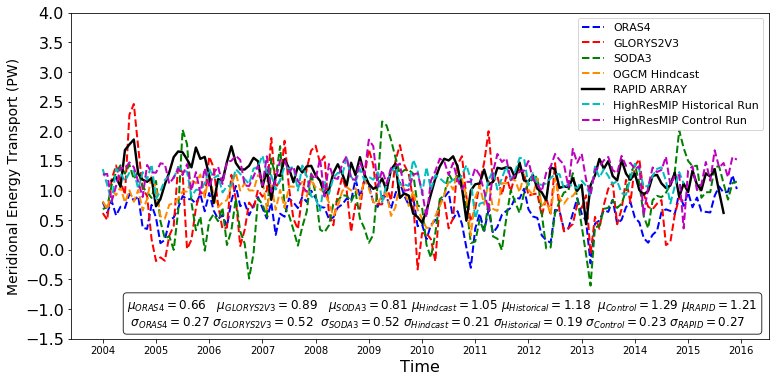

In [14]:
# RAPID
index = np.arange(1,12*12+1,1) # 2004 - 2015
index_RAPID_monthly = np.arange(3,len(OMET_RAPID_monthly)+3,1)

text_content = '$\mu_{ORAS4}=%.2f$   $\mu_{GLORYS2V3}=%.2f$   $\mu_{SODA3}=%.2f$ $\mu_{Hindcast}=%.2f$ $\mu_{Historical}=%.2f$  $\mu_{Control}=%.2f$ $\mu_{RAPID}=%.2f$ \n $\sigma_{ORAS4}=%.2f$ $\sigma_{GLORYS2V3}=%.2f$  $\sigma_{SODA3}=%.2f$ $\sigma_{Hindcast}=%.2f$ $\sigma_{Historical}=%.2f$ $\sigma_{Control}=%.2f$ $\sigma_{RAPID}=%.2f$'\
                % (OMET_ORAS4_mean, OMET_GLORYS2V3_mean, OMET_SODA3_mean, OMET_NEMO_mean, OMET_RAPID_hist_mean, OMET_RAPID_control_mean, OMET_RAPID_mean,
                   OMET_ORAS4_std, OMET_GLORYS2V3_std, OMET_SODA3_std, OMET_NEMO_std, OMET_RAPID_hist_std, OMET_RAPID_control_std, OMET_RAPID_std)

fig1 = plt.figure()
#plt.plot(index_RAPID[:],OMET_RAPID[:-23],color='gray',linestyle='-',linewidth=1.4,label='RAPID ARRAY')
plt.plot(index[:],OMET_ORAS4_RAPID_series[:-12],'b--',linewidth=2.0,label='ORAS4')
plt.plot(index[:-12],OMET_GLORYS2V3_RAPID_series[:],'r--',linewidth=2.0,label='GLORYS2V3')
plt.plot(index,OMET_SODA3_RAPID_series[:],'g--',linewidth=2.0,label='SODA3')
plt.plot(index[:-36],OMET_hindcast_series[46*12:],color='darkorange',linestyle='--',linewidth=2.0,label='OGCM Hindcast')
plt.plot(index_RAPID_monthly[:],OMET_RAPID_monthly[:],color='black',linestyle='-',linewidth=2.4,label='RAPID ARRAY')
plt.plot(index[:-12],OMET_RAPID_hist[:],'c--',linewidth=2.0,label='HighResMIP Historical Run')
plt.plot(index,OMET_RAPID_control[:],'m--',linewidth=2.0,label='HighResMIP Control Run')
#plt.title('Meridional Energy Transport in the ocean at 26.5 N (02/04/2004 - 12/10/2015)')
plt.legend(frameon=True, loc=1, prop={'size': 11})
fig1.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize = 16)
plt.xticks(np.linspace(1, 12*12+1, 13), np.arange(2004,2017,1))
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (PW)",fontsize = 14)
plt.yticks(np.arange(-1.5,4.5,0.5),fontsize=16)
props = dict(boxstyle='round',facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.08,0.13,text_content,transform=ax.transAxes,fontsize=12,verticalalignment='top',bbox=props)
plt.show()
fig1.savefig(output_path + os.sep + 'Comp_OMET_26.5N_RAPID_highResMIP_reanalyses_hindcast_time_series.jpg', dpi = 200)

In [15]:
print ('***********!@#$%^&*  OMET time series !@#$%^&***********')
print ('Prepare data for plots!')
# time series for comparison
OMET_ORAS4_series = OMET_ORAS4_OSNAP_int.reshape(len(year_ORAS4)*12)
#OMET_GLORYS2V3_series = OMET_GLORYS2V3[:,:,lat_GLORYS2V3_60_cut].reshape(len(year_GLORYS2V3)*12)
OMET_SODA3_series = OMET_SODA3_OSNAP_int.reshape(len(year_SODA3)*12)
# pick-up series for certain period
# pay attention to time
# from Aug 2014 to April 2016 (21 months)
OMET_ORAS4_series_pickup = OMET_ORAS4_series[10*12+7:10*12+7+21]
OMET_SODA3_series_pickup = OMET_SODA3_series[10*12+7:]
# series index
index = np.arange(21) # Aug 2014 to April 2016 (21 months)
index_time = ['201408','201411','201502','201505','201508','201511',
              '201602','201605']

***********!@#$%^&*  OMET time series !@#$%^&***********
Prepare data for plots!


In [16]:
# calculate the mean of OMET
# OSNAP
print('mean of OMET - ORAS4')
OMET_ORAS4_mean = np.mean(OMET_ORAS4_series)
#print('mean of OMET - GLORYS2V3')
#OMET_GLORYS2V3_mean = np.mean(OMET_GLORYS2V3_series)
print('mean of OMET - SODA3')
OMET_SODA3_mean = np.mean(OMET_SODA3_series)

OMET_OSNAP_mean = np.mean(OMET_OSNAP)
print('mean of OMET - OSNAP')
print (OMET_OSNAP_mean)

OMET_OSNAP_control_mean = np.mean(OMET_OSNAP_control)
print ('The mean of OMET from control run is (in peta Watt):')
print (OMET_OSNAP_control_mean)

mean of OMET - ORAS4
mean of OMET - SODA3
mean of OMET - OSNAP
0.45488913021239935
The mean of OMET from control run is (in peta Watt):
0.5698304016916865


In [17]:
# OSNAP
# standard deviation
print('std of OMET - ORAS4')
OMET_ORAS4_std = np.std(OMET_ORAS4_series)
print(OMET_ORAS4_std)
#print('std of OMET - GLORYS2V3')
#OMET_GLORYS2V3_std = np.std(OMET_GLORYS2V3_series)
print('std of OMET - SODA3')
OMET_SODA3_std = np.std(OMET_SODA3_series)

OMET_OSNAP_std = np.std(OMET_OSNAP)
print('std of OMET - OSNAP')
print(OMET_OSNAP_std)

OMET_OSNAP_control_std = np.std(OMET_OSNAP_control)
print ('The std of OMET from control run is (in peta Watt):')
print (OMET_OSNAP_control_std)

std of OMET - ORAS4
0.08377308332499231
std of OMET - SODA3
std of OMET - OSNAP
0.07333506355170205
The std of OMET from control run is (in peta Watt):
0.04262975383262866


In [40]:
print(len(OMET_ORAS4_series))

144


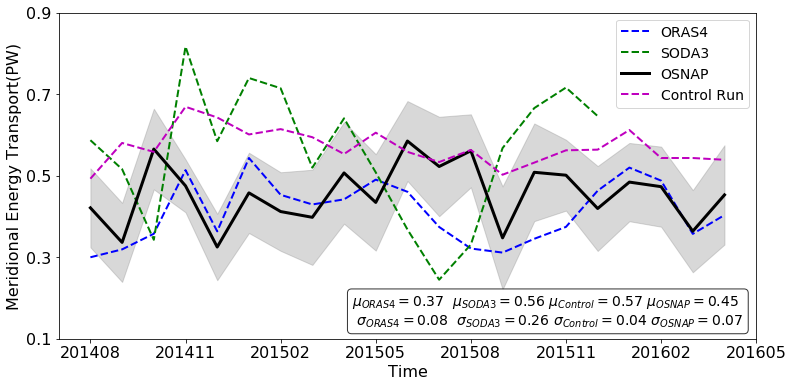

In [18]:
# OSNAP
# uncertainty of OSNAP
OMET_OSNAP_max = OMET_OSNAP + OMET_ERR_OSNAP
OMET_OSNAP_min = OMET_OSNAP - OMET_ERR_OSNAP
# series index
index = np.arange(21) # Aug 2014 to April 2016 (21 months)
index_time = ['201408','201411','201502','201505','201508','201511',
              '201602','201605']

text_content = '$\mu_{ORAS4}=%.2f$  $\mu_{SODA3}=%.2f$ $\mu_{Control}=%.2f$ $\mu_{OSNAP}=%.2f$ \n $\sigma_{ORAS4}=%.2f$  $\sigma_{SODA3}=%.2f$ $\sigma_{Control}=%.2f$ $\sigma_{OSNAP}=%.2f$ '\
                % (OMET_ORAS4_mean, OMET_SODA3_mean, OMET_OSNAP_control_mean, OMET_OSNAP_mean, OMET_ORAS4_std, OMET_SODA3_std, OMET_OSNAP_control_std, OMET_OSNAP_std)
# plot AMET time series
fig = plt.figure()
fig.set_size_inches(12.5, 6)
plt.plot(index[:], OMET_ORAS4_series_pickup,
         'b--', linewidth=2.0, label='ORAS4')
plt.plot(index[:-4], OMET_SODA3_series_pickup,
         'g--', linewidth=2.0, label='SODA3')
plt.plot(index[:], OMET_OSNAP, 'k-', linewidth=3.0, label='OSNAP')
plt.fill_between(index[:],OMET_OSNAP_max,
                 OMET_OSNAP_min,alpha=0.3,edgecolor='gray', facecolor='gray')
plt.plot(index[:], OMET_OSNAP_control, 'm--', linewidth=2.0, label='Control Run')
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(0,len(index)+1,3), index_time,fontsize=16)
plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
plt.yticks(np.arange(0.1,1.0,0.2),fontsize=16)
plt.legend(frameon=True, loc=1, prop={'size': 14})
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.42,0.14,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig.savefig(os.path.join(output_path,'OMET_highResMIP_reanalyses_hindcast_series_OSNAP.png'),dpi=200)
plt.close(fig)